<a href="https://colab.research.google.com/github/MuhammadBinTariq/ATML_PA0/blob/main/Task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 2: Understanding Vision Transformers (ViT)

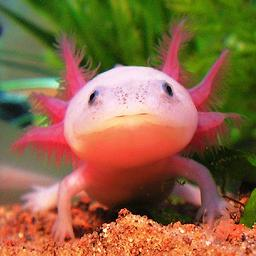

In [ ]:
import torch
from torch import Tensor
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from transformers import ViTForImageClassification, ViTImageProcessor, ViTFeatureExtractor

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load pre-trained model and feature extractor (processor)
vit_model_name = "google/vit-base-patch16-224"
vit_processor = ViTImageProcessor.from_pretrained(vit_model_name)
vit_model = ViTForImageClassification.from_pretrained(
    vit_model_name,
    attn_implementation='eager' # returns attn weights
).to(device)

axolotl_image = Image.open('./ax.jpg')
# candle_image = Image.open('./can.jpg')

# Visualize our sample images (from ImageNet)
display(axolotl_image)
# display(candle_image)

In [ ]:
# Prepare input images (pre-processing)
inputs = vit_processor(images=axolotl_image, return_tensors='pt')
# inputs = vit_processor(images=[axolotl_image, candle_image], return_tensors='pt')

# print(inputs['pixel_values'])
# print(inputs)

with torch.no_grad():
    outputs = vit_model(**inputs, output_attentions=True)

logits = outputs.logits
axolotl_predicted_idx = logits[0].argmax(-1).item()
# candle_predicted_idx = logits[1].argmax(-1).item()

print("Predicted Class for Axolotl Image: ", vit_model.config.id2label[axolotl_predicted_idx])
# print("Predicted Class for Candle Image: ", vit_model.config.id2label[candle_predicted_idx])


Predicted Class for Axolotl Image:  axolotl, mud puppy, Ambystoma mexicanum


In [ ]:
# Retrieving the attentions
vit_attentions = outputs.attentions
# print(type(vit_attentions))
# print(len(vit_attentions))

attn_mat_last = vit_attentions[-1]
print(attn_mat_last.shape)  # [Batch Size, Num of Heads, Seq Len, Seq Len] = [2, 12, 197, 197] when 2 images

# Aggregate the heads for simplicity
aggregate_attn = torch.mean(attn_mat_last, dim=1)

# The first token is the CLS token
cls_attentions = aggregate_attn[0, 0, :]    # Tells us how much attention the CLS token paid to 197 tokens (including itself)
patch_attentions = cls_attentions[1:]       # Excluding CLS from itself
# print(torch.sum(patch_attentions))
print(patch_attentions.shape)   # [196]

# Resize this vector to 2D spatial arrangment of patches: 224x224 image with 16x16 patches -> 224/16 = 14 -> 14 x 14 = 196 patches
attention_map = patch_attentions.reshape(14, 14).cpu().numpy()

# print(cls_attentions)
# print(aggregate_attn)


torch.Size([1, 12, 197, 197])
torch.Size([196])


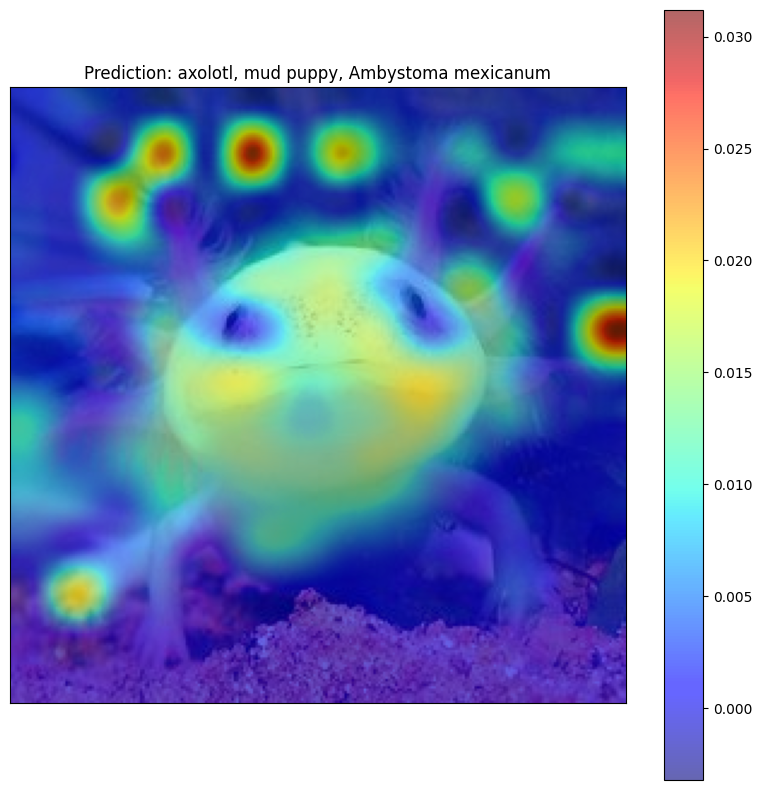

In [ ]:
import cv2
# Upsample using interpolation. cv2.INTER_CUBIC is good for enlarging.
attention_upsampled = cv2.resize(attention_map, axolotl_image.size, interpolation=cv2.INTER_CUBIC)
# cv2.resize handles the normalization for you based on the input data type.

# Create a figure and axis
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# 1. Display the original image
ax.imshow(axolotl_image)

# 2. Overlay the attention heatmap
# 'jet' or 'inferno' or 'hot' are good colormaps for heatmaps.
# `alpha` controls transparency: 0.0 is fully transparent, 1.0 is fully opaque. 0.5 is a good start.
im = ax.imshow(attention_upsampled, cmap='jet', alpha=0.6)

# Optional: Add a colorbar to show the intensity scale
plt.colorbar(im, ax=ax)

# Remove axes ticks for a cleaner look
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(f"Prediction: {vit_model.config.id2label[axolotl_predicted_idx]}")

plt.tight_layout()
plt.show()

### Analyze the Attention Map

In [ ]:
print(inputs['pixel_values'].shape)
inputs['pixel_values'].shape[-1]

torch.Size([1, 3, 224, 224])


224

In [ ]:
# Mask a fraction of input patches and observe the effect on accuracy

# We define two functions - one for random masking and one for structured masking

# def random_mask(pixel_values: Tensor, mask_ratio):

#     # Clone the input
#     masked_values = pixel_values.clone()

#     # Calculate num patches
#     num_patches = pixel_values.shape[-1] // 16  # Assuming square images
#     num_masked = int(num_patches * mask_ratio)

#     # Randomly generate "patch" numbers and select num_masked of these
#     patch_permutation = torch.randperm(num_patches)
#     patches_idx = patch_permutation[:num_masked]

#     # Translate between patch number and tensor indices
#     # Assuming patch no. increases left to right
#     for idx in patches_idx:
#         patch_row = idx // 14   # Since 14 patches per row (and col)
#         patch_col = idx % 14

#         tensor_row, tensor_col = patch_row * 16, patch_col * 16     # Origin point for the patch
#         row_end, col_end = tensor_row + 16, tensor_col + 16

#         masked_values[:, :, tensor_row:row_end, tensor_col:col_end] = 0

#     return masked_values
def random_mask(pixel_values: Tensor, mask_ratio: float=0.5): # Also, type hint should be float
    """
    Args:
        pixel_values: Input tensor of shape (1, 3, H, W)
        mask_ratio: Fraction of patches to mask (0.0 to 1.0)
    """
    masked_values = pixel_values.clone()

    # Get image height and width (assuming H == W for simplicity)
    img_size = pixel_values.shape[-1]
    patch_size = 16

    # Calculate the NUMBER OF PATCHES ALONG ONE DIMENSION
    grid_size = img_size // patch_size # e.g., 224//16 = 14
    # Calculate the TOTAL NUMBER of patches
    total_num_patches = grid_size ** 2 # e.g., 14*14 = 196

    num_masked = int(total_num_patches * mask_ratio)

    # Randomly generate indices for the total number of patches
    patch_permutation = torch.randperm(total_num_patches)
    patches_idx = patch_permutation[:num_masked]

    # Translate between flat patch index and 2D grid position
    for idx in patches_idx:
        # Convert the flat index (0-195) to grid coordinates (0-13, 0-13)
        patch_row = idx // grid_size   # This is the correct divisor now
        patch_col = idx % grid_size

        tensor_row = patch_row * patch_size
        tensor_col = patch_col * patch_size
        row_end = tensor_row + patch_size
        col_end = tensor_col + patch_size

        masked_values[:, :, tensor_row:row_end, tensor_col:col_end] = 0

    return masked_values

# Masking the center
def structured_mask(pixel_values: Tensor, size: int):

    size = min(size, pixel_values.shape[-1])

    masked_input = pixel_values.clone()

    row = (pixel_values.shape[-1] - size) // 2
    col = row

    masked_input[:, :, row:row + size, col:col+size] = 0

    return masked_input

In [ ]:
# Mask the input and pass repeat step 1

copy_tensor_rand = inputs['pixel_values'].clone()
copy_tensor_struct = inputs['pixel_values'].clone()

copy_tensor_rand = random_mask(copy_tensor_rand, 0.5)
copy_tensor_struct = structured_mask(copy_tensor_struct, 112)

# print(copy_tensor_rand)

rand_input = {'pixel_values':copy_tensor_rand}
struct_input = {'pixel_values':copy_tensor_struct}

with torch.no_grad():
    rand_outputs = vit_model(**rand_input, output_attentions=True)
    struct_outputs = vit_model(**struct_input, output_attentions=True)

rand_logits = rand_outputs.logits
struct_logits = struct_outputs.logits

axolotl_predicted_rand = rand_logits[0].argmax(-1).item()
axolotl_predicted_struct = struct_logits[0].argmax(-1).item()
# candle_predicted_idx = logits[1].argmax(-1).item()

print("Predicted Class for Axolotl Image with Random Masking: ", vit_model.config.id2label[axolotl_predicted_rand])
print("Predicted Class for Axolotl Image with Structured Masking: ", vit_model.config.id2label[axolotl_predicted_struct])
# print("Predicted Class for Candle Image: ", vit_model.config.id2label[candle_predicted_idx])

Predicted Class for Axolotl Image with Random Masking:  axolotl, mud puppy, Ambystoma mexicanum
Predicted Class for Axolotl Image with Structured Masking:  axolotl, mud puppy, Ambystoma mexicanum
